In [2]:
import glob
from janome.tokenizer import Tokenizer
from datetime import datetime

## 歌詞を読み込む

uta-net のアーティストの歌詞一覧リストから歌詞を全て取得し、保存する。

```bash
$ cd analyse-artist
$ python get-liryc-uta-net.py https://www.uta-net.com/artist/9867/
```


In [3]:
# 歌詞の読み込み
lyrics = []
for path in glob.glob("lyrics/*.txt"):
    with open(path, "r") as f:
        lines = f.readlines()
        if len(lines) < 3:
            print("invalid format: {}".format(path))
        title = lines[0].strip()
        date = datetime.strptime(lines[1].strip(), "%Y/%m/%d")
        lyric = lines[2].strip()
        lyrics.append(
            {
                "title": title,
                "date": date,  # datetime.datetime
                "lyric": lyric,
            }
        )
# lyrics: [{'title': '...', 'date': datetime.datetime(2018, 1, 1, 0, 0), 'lyric': '...'}, ...]
# for lyric in lyrics:
#     print(lyric)

## 歌詞をトークン化する

```python
{
    "xx": {
        "songs_count": int, # いくつの曲で使われているか
        "count": int,       # 全体で何回使われているか
        "years": [int],　　　# 言葉が使われた曲の発表年のリスト
    }
}
```


In [4]:
tokenizer = Tokenizer()
words_dict = {}

for lyric in lyrics:
    title, date, lyric = lyric.values()
    song_words = set()
    for token in tokenizer.tokenize(lyric):
        base_form = token.base_form
        if token.part_of_speech.split(",")[0] not in ["名詞", "動詞", "形容詞"]:
            continue
        if base_form in words_dict:
            already_counted = 0 if (base_form in song_words) else 1
            words_dict[base_form] = {
                "songs_count": words_dict[base_form]["songs_count"] + already_counted,
                "count": words_dict[base_form]["count"] + 1,
                "years": words_dict[base_form]["years"] + [date.year] * already_counted,
            }
        else:
            words_dict[base_form] = {
                "songs_count": 1,
                "count": 1,
                "years": [date.year],
            }
        song_words.add(base_form)

## ワードクラウドで可視化


In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc"

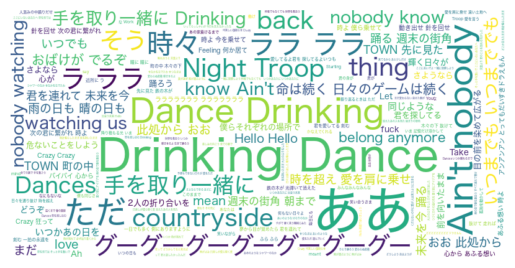

In [6]:
# wordcloud
# トークン化しない

text = " ".join([l["lyric"] for l in lyrics])
wordcloud = WordCloud(
    font_path=font_path, background_color="white", width=800, height=400
).generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png")

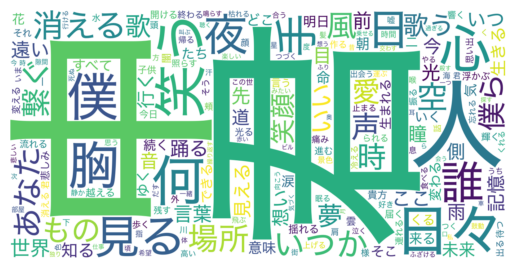

In [7]:
# トークン化した後のデータからwordcloudを作成する
text = ""
for lyric in lyrics:
    title, date, lyric = lyric.values()
    tokens = tokenizer.tokenize(lyric)
    text += " ".join(
        {
            t.base_form
            for t in tokens
            if (
                not t.base_form
                in [
                    "こと",
                    "よう",
                    "て",
                    "いる",
                    "ない",
                    "さ",
                    "まま",
                    "てる",
                    "の",
                    "する",
                    "なる",
                    "れる",
                    "ある",
                    "ん",
                    "せる",
                ]
            )
            and (t.part_of_speech.split(",")[0] in ["名詞", "動詞", "形容詞"])
        }
    )

wordcloud = WordCloud(
    font_path=font_path, background_color="white", width=1600, height=800
).generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png")

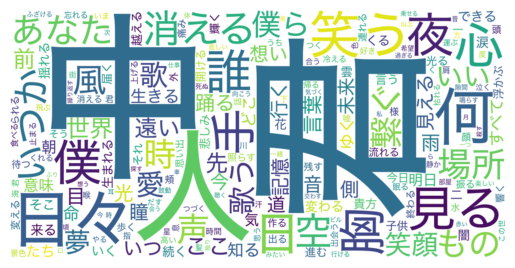

In [8]:
# トークン化した後のデータから同じ曲の中での重複を消してwordcloudを作成する
text = ""
for lyric in lyrics:
    title, date, lyric = lyric.values()
    tokens = tokenizer.tokenize(lyric)
    tokens_list = [
        t.base_form
        for t in tokens
        if (
            not t.base_form
            in [
                "こと",
                "よう",
                "て",
                "いる",
                "ない",
                "さ",
                "まま",
                "てる",
                "の",
                "する",
                "なる",
                "れる",
                "ある",
                "ん",
                "せる",
            ]
        )  # 特徴のない単語を除外
        and (t.part_of_speech.split(",")[0] in ["名詞", "動詞", "形容詞"])
    ]
    tokens_list = list(set(tokens_list))
    text += " ".join(tokens_list)

wordcloud = WordCloud(
    font_path=font_path, background_color="white", width=1600, height=800
).generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png")

## 単語が使われる回数の年毎の推移

In [9]:
import collections
def count_word_by_year(word):    
    c = collections.Counter(words_dict[word]["years"])
    c = sorted(c.items(), key=lambda x: x[0])
    return c
count_word_by_year("肌")

[(2017, 1), (2018, 1), (2019, 1), (2023, 1)]

# 年毎の曲数の推移

In [10]:
years = [l["date"].year for l in lyrics]
c = collections.Counter(years)
c = sorted(c.items(), key=lambda x: x[0])
c

[(2010, 13),
 (2011, 15),
 (2012, 13),
 (2013, 10),
 (2014, 4),
 (2015, 13),
 (2016, 4),
 (2017, 4),
 (2018, 13),
 (2019, 4),
 (2020, 2),
 (2021, 5),
 (2022, 2),
 (2023, 1)]

## BERTによる文章のベクトル化

参考：https://techblog.gmo-ap.jp/2022/12/21/bert_calc_sentence_similarity/

In [11]:

from transformers import BertJapaneseTokenizer, BertModel
 
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
 
import torch
import numpy as np

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

/Users/nanaco.s/workspace/dev/analyse-artist/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:

def sentence_to_vector(model, tokenizer, sentence):
    # 文を単語に区切って数字にラベル化
    tokens = tokenizer(sentence)["input_ids"]
    
    # BERTモデルの処理のためtensor型に変換
    input = torch.tensor(tokens).reshape(1,-1)
    
    # BERTモデルに入力し文のベクトルを取得
    with torch.no_grad():
        outputs = model(input, output_hidden_states=True)
        last_hidden_state = outputs.last_hidden_state[0]
        averaged_hidden_state = last_hidden_state.sum(dim=0) / len(last_hidden_state) 
    
    return averaged_hidden_state

In [13]:
sentence_to_vector(model, tokenizer, lyrics[2]['lyric'])

tensor([-7.4699e-02, -5.4213e-02, -2.7658e-01, -2.3606e-01, -2.8049e-01,
         8.0988e-02,  2.0656e-01,  5.8020e-02,  4.1882e-01, -1.1768e-01,
        -2.3028e-01, -2.8635e-01,  2.4001e-02,  2.6300e-03, -8.9069e-02,
         5.9292e-02, -6.0802e-02,  3.7061e-01,  2.1824e-01, -1.8232e-01,
         6.9890e-02, -2.4620e-02, -2.5767e-01,  1.0161e-01, -3.2684e-01,
         2.4785e-01,  2.7089e-01, -4.1388e-01,  7.1803e-02, -2.9353e-01,
        -4.2423e-01,  2.0438e-01, -8.5915e-01, -4.1065e-02,  5.3118e-03,
         2.2692e-01,  3.8057e-02, -2.3052e-01,  2.1142e-01, -2.1979e-01,
         3.9512e-01, -4.8889e-02, -1.0287e-01,  4.6801e-02,  5.8038e-01,
         8.6928e-02,  1.9151e-01,  1.7882e-04,  2.9221e-01,  2.3170e-01,
        -5.7431e-02,  1.8759e-01,  3.2244e-01, -4.8606e-02,  2.0509e-01,
         8.6681e-02, -2.8411e-02,  4.8150e-01, -1.7037e-01,  4.6794e-01,
         3.6895e-01, -3.4345e-01, -1.7527e-01, -2.5512e-01, -1.5784e-01,
        -5.6992e-01,  3.5706e-01, -5.6336e-02,  1.6

In [14]:
def calc_similarity(sentence1, sentence2):
    # print("{}\n{}".format(sentence1, sentence2))
    
    sentence_vector1 = sentence_to_vector(model, tokenizer, sentence1)
    sentence_vector2 = sentence_to_vector(model, tokenizer, sentence2)

    score = torch.nn.functional.cosine_similarity(sentence_vector1, sentence_vector2, dim=0).detach().numpy().copy()
    # print("類似度：", score)
    return score

In [35]:
samples = lyrics
def all_similarity(lyrics_):
    scores = np.empty(shape=(len(lyrics_), len(lyrics_)))
    titles = [lyric['title'] for lyric in lyrics_]
    for i in range(0, len(lyrics_)):
        for j in range(i+1, len(lyrics_)):
            try:
                score = calc_similarity(lyrics_[i]['lyric'], lyrics_[j]['lyric'])
                # print(lyrics_[i]['title'], lyrics_[j]['title'], score)
                scores[i][j] = score
            except:
                print(lyrics_[i]['title'], lyrics_[j]['title'])
    return scores, titles
scores, titles = all_similarity(samples)
print(scores)

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


マッドメン(House ver.) Same Thing (feat. Superorganism)
バイト Same Thing (feat. Superorganism)
Night Troop Same Thing (feat. Superorganism)
パロディ Same Thing (feat. Superorganism)
Snow Men Same Thing (feat. Superorganism)
布団 Same Thing (feat. Superorganism)
くせのうた Same Thing (feat. Superorganism)
Hello Song Same Thing (feat. Superorganism)
茶碗 Same Thing (feat. Superorganism)
営業 Same Thing (feat. Superorganism)
喜劇 Same Thing (feat. Superorganism)
Moon Sick Same Thing (feat. Superorganism)
ダンサー Same Thing (feat. Superorganism)
The Shower Same Thing (feat. Superorganism)
Nothing Same Thing (feat. Superorganism)
ミスユー Same Thing (feat. Superorganism)
そしたら Same Thing (feat. Superorganism)
季節 Same Thing (feat. Superorganism)
落下(House ver.) Same Thing (feat. Superorganism)
Crazy Crazy Same Thing (feat. Superorganism)
雨音 (House ver.) Same Thing (feat. Superorganism)
くだらないの中に Same Thing (feat. Superorganism)
Present Same Thing (feat. Superorganism)
夜 Same Thing (feat. Superorganism)
ここにいないあなたへ Same Thing 

In [44]:
scores.argmax() % len(samples)
print("most similar: ", 
      titles[int(scores.argmax() // len(samples))], 
      titles[int(scores.argmax() % len(samples))], 
      scores.max())
print("least similar: ", 
      titles[int(scores.argmin() // len(samples))],
      titles[int(scores.argmin() % len(samples))]
      , scores.min())


most similar:  恋 キッチン 298644.5629915799
least similar:  Family Song もしも -54683.77351157265


'キッチン'